In [552]:
import pandas as pd
from pandas import Series, DataFrame
from matplotlib import pyplot as plt
import os
import seaborn as sns


In [4]:
df = pd.read_csv('Data/circuits.csv')

In [5]:
data = {'filename':'circuts.csv', 'columns':df.columns}

df2 = DataFrame(data)

# TODO: Could deep-dive into file navigation and operations in Python



In [8]:
df_columns = None

for filename in os.listdir('Data'):
  if (filename != '.git'):
    df_columns_tmp = DataFrame(
      {
        'filename': filename,
        'columns': pd.read_csv('Data/'+ filename).columns
      }
    )
    if df_columns is not None:
      df_columns = df_columns.append(df_columns_tmp)
    elif df_columns is None:
      df_columns = df_columns_tmp

df_columns.to_csv('Metadata.csv')

In [433]:
#initialize dataframes

df_qualifying = pd.read_csv('Data/qualifying.csv')
df_races = pd.read_csv('Data/races.csv')
df_results = pd.read_csv('Data/results.csv')
df_drivers = pd.read_csv('Data/drivers.csv')
df_constructors = pd.read_csv('Data/constructors.csv')
df_seasons = pd.read_csv('Data/Seasons.csv')
df_driverStandings = pd.read_csv('Data/DriverStandings.csv')
df_constructorStandings = pd.read_csv('Data/ConstructorStandings.csv')

In [252]:
# For what percentage of races did the winner of qualifying go on to win the race?
def get_unique_value_counts(dataframe):
  result = {'count_records':dataframe.shape[0]}
  for column in dataframe.columns:
    result[f'count_{column}'] = dataframe[column].nunique()

  return DataFrame(result,index=[0])

In [88]:
get_unique_value_counts(df_results)

,count_records,count_resultId,count_raceId,count_driverId,count_constructorId,count_number,count_grid,count_position,count_positionText,count_positionOrder,count_points,count_laps,count_time,count_milliseconds,count_fastestLap,count_rank,count_fastestLapTime,count_fastestLapSpeed,count_statusId
0,23777,23777,976,842,207,128,35,33,39,39,33,172,5758,5966,77,25,551,5144,132


In [89]:
get_unique_value_counts(df_qualifying)

,count_records,count_qualifyId,count_raceId,count_driverId,count_constructorId,count_number,count_position,count_q1,count_q2,count_q3
0,7516,7516,345,153,41,49,28,6736,3481,2121


In [90]:
get_unique_value_counts(df_drivers)

,count_records,count_driverId,count_driverRef,count_number,count_code,count_forename,count_surname,count_dob,count_nationality,count_url
0,842,842,842,37,81,466,785,823,41,841


In [553]:
df_results.drop_duplicates(subset=['raceId','positionOrder'], keep=False, inplace=True)
df_results[df_results.duplicated(subset=['raceId','positionOrder'])]

# TODO: Better understand why duplicates exist in the results dataframe


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId


In [92]:
# df_qualifying[df_qualifying.duplicated(subset=['raceId','position'], keep=False)]
df_races.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [582]:
df_tmp = df_results.merge(df_qualifying,on=['raceId','driverId'],suffixes=['_result','_qual'])

# check for duplicates
df_tmp[df_tmp.duplicated(subset=['raceId','driverId'])]

# TODO: Might be interesting to generally know how qualifying placement affects race day placement

# For what percentage of races did the winner of qualifying go on to win the race?
df_tmp[df_tmp.position_qual == 1]['position_result'].value_counts(normalize=True)
df_tmp[df_tmp.position_result == 1]['position_qual'].value_counts(normalize=True)

1     0.495652
2     0.257971
3     0.098551
4     0.052174
5     0.028986
6     0.020290
7     0.014493
8     0.005797
10    0.005797
11    0.005797
9     0.002899
14    0.002899
15    0.002899
16    0.002899
17    0.002899
Name: position_qual, dtype: float64

In [ ]:
# TODO: show that before filtering - the Indianapolis 500 results skew the numbers

In [531]:
# remove race results for the Indianapolis 500
df_results = df_results[~df_results.raceId.isin(df_races[df_races.name == 'Indianapolis 500'].raceId)]

# remove drivers that did not race the average number of races for a season
df_results = df_results[
  df_results.driverId.isin(
    df_results.driverId.value_counts()[
      df_results.driverId.value_counts() >= 15].index
      )
    ]

# remove drivers that are no longer in the race results
df_drivers = df_drivers[df_drivers.driverId.isin(df_results.driverId)]

#remove constructors that are no longer in the race results
df_constructors = df_constructors[df_constructors.constructorId.isin(df_results.constructorId)]


Text(0, 0.5, 'Nationalities')

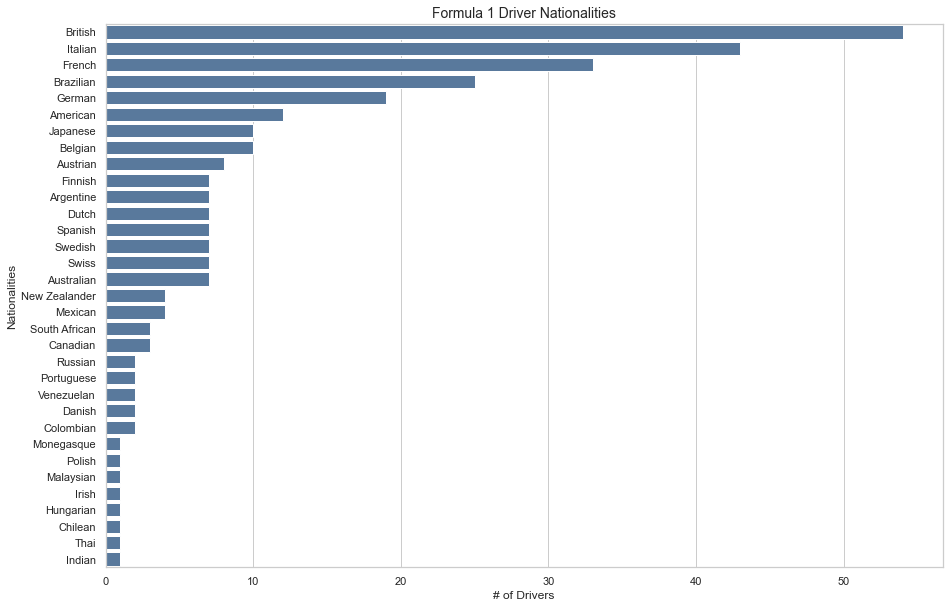

In [587]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(15,10))

# What is the distribution of nationalities for Formula 1 drivers?
df_tmp = df_drivers.groupby('nationality',as_index=False)\
  .agg(count_drivers = pd.NamedAgg(column='driverId',aggfunc='nunique'))\
  .sort_values('count_drivers',ascending=False)

graph = sns.barplot(
    data=df_tmp,
    y ='nationality',
    x='count_drivers',
    color='#4e79a7'
     ).set_title(
    'Formula 1 Driver Nationalities',
    size=14
    )
plt.xlabel('# of Drivers')
plt.ylabel('Nationalities')


# TODO: It could be interesting to see the geographic frequency of races on a map

Text(0, 0.5, 'Nationalities')

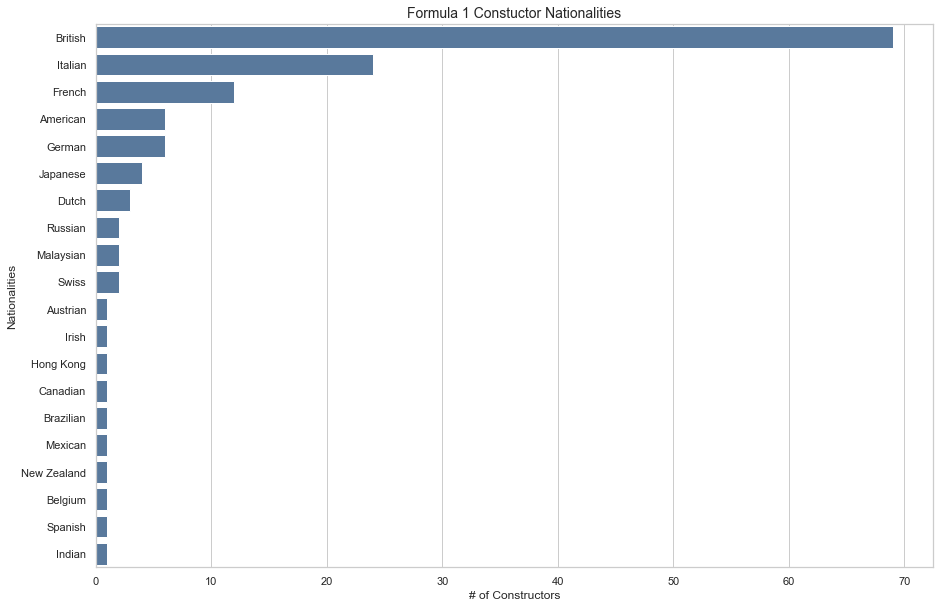

In [588]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(15,10))

# What is the distribution of nationalities for Formula 1 drivers?
df_tmp = df_constructors.groupby('nationality',as_index=False)\
  .agg(count_constructors = pd.NamedAgg(column='constructorId',aggfunc='nunique'))\
  .sort_values('count_constructors',ascending=False)

graph = sns.barplot(
    data=df_tmp,
    y ='nationality',
    x='count_constructors',
    color='#4e79a7'
     ).set_title(
    'Formula 1 Constuctor Nationalities',
    size=14
    )
plt.xlabel('# of Constructors')
plt.ylabel('Nationalities')


# TODO: It could be interesting to see the geographic frequency of races on a map

In [629]:
# get driver, season, total points
df_tmp = df_driverStandings \
  .merge(df_results, on=['raceId','driverId'],suffixes=['_standing','_result']) \
  .merge(df_races, on='raceId', suffixes=['_standing','_race'])\
  .merge(df_drivers, on='driverId',suffixes=['_standing','_driver'])\
  .merge(df_constructors, on='constructorId',suffixes=['_driver','_constructor'])

df_tmp2 = df_tmp.groupby(['year'], as_index=False).agg({'points_standing':'max'})

df_tmp3 = df_tmp.merge(df_tmp2, on=['year','points_standing'])\
  .drop_duplicates(subset=['year','points_standing','driverId'],keep='first')

# which drivers have the most titles?
df_tmp4 = df_tmp3.groupby(['surname','forename','nationality_driver','driverId'], as_index=False)\
  .agg(count_year = pd.NamedAgg(column='year',aggfunc='count'))\
  .sort_values(by='count_year', ascending=False)

# which nations have the most driver's titles?
df_tmp5 = df_tmp4.groupby('nationality_driver',as_index=False)\
  .agg(count_titles = pd.NamedAgg(column='count_year',aggfunc='sum'))\
  .sort_values(by='count_titles',ascending=False)[:10]

# from IPython.display import display,Markdown
display(Markdown('### Nations with the most driver\'s championships.'))
display(df_tmp5)

# which nations have the most driver champions?
df_tmp5 = df_tmp4.groupby('nationality_driver',as_index=False)\
  .agg(count_drivers=pd.NamedAgg(column='driverId',aggfunc='nunique'))\
  .sort_values(by='count_drivers',ascending=False)[:10]

display(Markdown('### Nations with the most driver\'s *champions*.'))
display(df_tmp5)

# which drivers has won the most races in all Formula One history?
df_driver_wins = df_tmp[df_tmp.position_result==1]\
  .groupby(['driverId','surname','forename'],as_index=False)\
  .agg(count_wins=pd.NamedAgg(column='raceId',aggfunc='nunique'))\
  .sort_values(by='count_wins',ascending=False)

display(Markdown('### Formula 1 drivers with the most wins. '))
display(df_driver_wins[:10])

# who are winning drivers that never won a driver's championship?
df_tmp5 = df_driver_wins[~df_driver_wins.driverId.isin(df_tmp3.driverId.values)]

display(Markdown('### Top drivers that never won a driver''s championship.'))
display(df_tmp5[:10])


### Nations with the most driver's championships.

,nationality_driver,count_titles
5,British,17
9,German,12
4,Brazilian,8
1,Argentine,5
2,Australian,4
3,Austrian,4
7,Finnish,4
8,French,4
10,Italian,3
0,American,2


### Nations with the most driver's *champions*.

,nationality_driver,count_drivers
5,British,10
4,Brazilian,3
7,Finnish,3
9,German,3
0,American,2
2,Australian,2
3,Austrian,2
10,Italian,2
1,Argentine,1
6,Canadian,1


### Formula 1 drivers with the most wins. 

,driverId,surname,forename,count_wins
15,30,Schumacher,Michael,91
0,1,Hamilton,Lewis,62
29,117,Prost,Alain,51
11,20,Vettel,Sebastian,47
27,102,Senna,Ayrton,41
2,4,Alonso,Fernando,32
26,95,Mansell,Nigel,31
64,328,Stewart,Jackie,27
40,182,Lauda,Niki,25
73,373,Clark,Jim,25


### Top drivers that never won a drivers championship.

,driverId,surname,forename,count_wins
80,475,Moss,Stirling,15
7,14,Coulthard,David,13
42,199,Reutemann,Carlos,12
13,22,Barrichello,Rubens,11
6,13,Massa,Felipe,11
55,238,Peterson,Ronnie,10
25,77,Berger,Gerhard,10
9,17,Webber,Mark,9
54,235,Ickx,Jacky,8
34,163,Arnoux,Ren̩,7


In [500]:
# get constructor, total season points

df_tmp = df_constructorStandings\
  .merge(df_races,on=['raceId'],suffixes=['_standing','_race'])\
  .merge(df_constructors, on=['constructorId'],suffixes=['_races','_constructor'])

# TODO: Would like to figure understand how to control column aliases a little more when merging
# df_tmp.groupby(['year','name_constructor']).agg(max_points=pd.NamedAgg(column='points_standings_standing',aggfunc='max'))
df_tmp2 = df_tmp.groupby(['year'],as_index=False)\
  .agg(max_points=pd.NamedAgg(column='points',aggfunc='max'))

df_tmp3 = df_tmp.merge(
    df_tmp2, left_on=['year','points'],
    right_on=['year','max_points']
  ).drop_duplicates(subset=['year','constructorId'])

# which constructor has the most championships?
df_tmp3.groupby(['constructorId','name_constructor','nationality'],as_index=False)\
  .agg(count_years=pd.NamedAgg(column='year',aggfunc='nunique'))\
  .sort_values(by='count_years',ascending=False)

# which nation has the most constructors championships?
df_tmp3.groupby(['nationality'],as_index=False)\
  .agg(count_years=pd.NamedAgg(column='year',aggfunc='nunique'))\
  .sort_values(by='count_years',ascending=False)


,constructorStandingsId,raceId,constructorId,points,position,positionText,wins,Unnamed: 7,year,round,circuitId,name_races,date,time,url_races,constructorRef,name_constructor,nationality,url_constructor,Unnamed: 5
0,1,18,1,14.0,1,1,1,NaN,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
1,7,19,1,24.0,1,1,1,NaN,2008,2,2,Malaysian Grand Prix,2008-03-23,07:00:00,http://en.wikipedia.org/wiki/2008_Malaysian_Gr...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
2,18,20,1,28.0,3,3,1,NaN,2008,3,3,Bahrain Grand Prix,2008-04-06,11:30:00,http://en.wikipedia.org/wiki/2008_Bahrain_Gran...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
3,29,21,1,34.0,3,3,1,NaN,2008,4,4,Spanish Grand Prix,2008-04-27,12:00:00,http://en.wikipedia.org/wiki/2008_Spanish_Gran...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
4,40,22,1,42.0,3,3,1,NaN,2008,5,5,Turkish Grand Prix,2008-05-11,12:00:00,http://en.wikipedia.org/wiki/2008_Turkish_Gran...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11891,26644,964,209,1.0,10,10,0,NaN,2016,17,22,Japanese Grand Prix,2016-10-09,05:00:00,https://en.wikipedia.org/wiki/2016_Japanese_Gr...,manor,Manor Marussia,British,http://en.wikipedia.org/wiki/Manor_Motorsport,NaN
11892,26721,967,209,1.0,11,11,0,NaN,2016,20,18,Brazilian Grand Prix,2016-11-13,16:00:00,https://en.wikipedia.org/wiki/2016_Brazilian_G...,manor,Manor Marussia,British,http://en.wikipedia.org/wiki/Manor_Motorsport,NaN
11893,26699,965,209,1.0,10,10,0,NaN,2016,18,69,United States Grand Prix,2016-10-23,19:00:00,https://en.wikipedia.org/wiki/2016_United_Stat...,manor,Manor Marussia,British,http://en.wikipedia.org/wiki/Manor_Motorsport,NaN
11894,26710,966,209,1.0,10,10,0,NaN,2016,19,32,Mexican Grand Prix,2016-10-30,19:00:00,https://en.wikipedia.org/wiki/2016_Mexican_Gra...,manor,Manor Marussia,British,http://en.wikipedia.org/wiki/Manor_Motorsport,NaN


,driverStandingsId,raceId,driverId,points_standing,position_standing,positionText_standing,wins,resultId,constructorId,number_standing,...,forename,surname,dob,nationality_standing,url_driver,constructorRef,name_constructor,nationality_constructor,url,Unnamed: 5
0,355,35,1,98.0,1,1,5,353,1,22.0,...,Lewis,Hamilton,07/01/1985,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
1,11366,190,57,76.0,1,1,5,3634,1,1.0,...,Mika,H�_kkinen,28/09/1968,Finnish,http://en.wikipedia.org/wiki/Mika_H%C3%A4kkinen,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
2,4601,206,57,100.0,1,1,8,3983,1,8.0,...,Mika,H�_kkinen,28/09/1968,Finnish,http://en.wikipedia.org/wiki/Mika_H%C3%A4kkinen,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
3,17610,320,102,96.0,1,1,7,6980,1,1.0,...,Ayrton,Senna,21/03/1960,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
4,16350,334,102,78.0,1,1,6,7474,1,27.0,...,Ayrton,Senna,21/03/1960,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,52831,689,304,51.0,1,1,2,16801,191,2.0,...,Denny,Hulme,18/06/1936,New Zealander,http://en.wikipedia.org/wiki/Denny_Hulme,brabham-repco,Brabham-Repco,British,http://en.wikipedia.org/wiki/Brabham,NaN
94,48952,698,356,42.0,1,1,4,16967,191,5.0,...,Jack,Brabham,02/04/1926,Australian,http://en.wikipedia.org/wiki/Jack_Brabham,brabham-repco,Brabham-Repco,British,http://en.wikipedia.org/wiki/Brabham,NaN
95,50266,755,356,43.0,1,1,5,18269,170,2.0,...,Jack,Brabham,02/04/1926,Australian,http://en.wikipedia.org/wiki/Jack_Brabham,cooper-climax,Cooper-Climax,British,http://en.wikipedia.org/wiki/Cooper_Car_Company,NaN
96,62402,763,356,31.0,1,1,2,18446,170,12.0,...,Jack,Brabham,02/04/1926,Australian,http://en.wikipedia.org/wiki/Jack_Brabham,cooper-climax,Cooper-Climax,British,http://en.wikipedia.org/wiki/Cooper_Car_Company,NaN
